In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import wmfdata
from wmfdata import hive
from wmfdata.charting import comma_fmt, pct_fmt, M_fmt
from wmfdata.utils import pct_str

In [2]:
%matplotlib inline
wmfdata.charting.set_mpl_style()

In [3]:
m = pd.read_csv(
    "../metrics/metrics.tsv", 
    sep="\t",
    parse_dates=["month"]
).set_index("month")

# Wiki segments

In [4]:
def wiki_segment(w):
    next_10_wps = (
        "eswiki", "dewiki", "jawiki", "frwiki", "ruwiki",
        "itwiki", "zhwiki", "ptwiki", "plwiki", "nlwiki"
    )
    
    if w == "enwiki":
        return "English Wikipedia"
    elif w in next_10_wps:
        return "'next 10' Wikipedias"
    elif w == "commonswiki":
        return "Commons"
    elif w == "wikidatawiki":
        return "Wikidata"
    else:
        return "other projects"

# Global editors dataset

In [6]:
%%time
global_eds_r = hive.run("""
select 
    month,
    tenure,
    count(*) as eds,
    sum(cast(content_edits >= 5 as int)) as active_eds,
    sum(cast(content_edits >= 100 as int)) as very_active_eds
from (
    select
        month,
        user_name,
        sum(edits) as edits,
        sum(content_edits) as content_edits,
        if(
            trunc(min(user_registration), "MONTH") = month,
            "new",
            "returning"
        ) as tenure,
        max(bot_by_group) as bot -- `bot_by_group` uses both group and name strategies
    from neilpquinn.editor_month
    where 
        month >= "{start}" and
        user_id != 0
    group by month, user_name
) global_edits
where
    not bot
group by month, tenure
""".format(start="2001-01-01"))

CPU times: user 16 ms, sys: 16 ms, total: 32 ms
Wall time: 3min 16s


In [7]:
global_eds = (
    global_eds_r
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index(["month"])
    .pivot(columns="tenure")
    .fillna(0)
)

global_eds.tail()

eds           active_eds           very_active_eds          
tenure           new returning        new returning             new returning
month                                                                        
2019-11-01  113005.0  190631.0    16756.0   69092.0           310.0   13465.0
2019-12-01  104837.0  189567.0    15785.0   69454.0           321.0   13471.0
2020-01-01  122431.0  197718.0    18342.0   71887.0           376.0   14378.0
2020-02-01  115704.0  192888.0    18043.0   70189.0           356.0   13907.0
2020-03-01  117704.0  196543.0    18254.0   72189.0           492.0   14988.0

# Per-wiki editors dataset

In [10]:
wiki_eds_r = hive.run("""
select 
    wiki,
    database_group as site_group,
    month,
    tenure,
    count(*) as eds,
    sum(cast(content_edits >= 5 as int)) as active_eds,
    sum(cast(content_edits >= 100 as int)) as very_active_eds
from (
    select
        wiki,
        database_group,
        month,
        if(
            trunc(user_registration, "MONTH") = month,
            "new",
            "returning"
        ) as tenure,
        edits,
        content_edits
    from neilpquinn.editor_month
    inner join canonical_data.wikis
    on wiki = database_code
    where
        month >= "{start}" and
        user_id != 0 and
        not bot_by_group -- `bot_by_group` uses both group and name strategies
) wiki_editors
group by 
    wiki,
    database_group,
    month,
    tenure
order by
    wiki,
    database_group,
    month,
    tenure
limit 1000000
""".format(start="2015-01-01"))

In [11]:
wiki_eds = (
    wiki_eds_r
    .drop("site_group", axis=1)
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index(["wiki", "month"])
    .pivot(columns="tenure")
    .fillna(0)
)

wiki_eds.xs("enwiki").tail()

eds           active_eds           very_active_eds          
tenure          new returning        new returning             new returning
month                                                                       
2019-11-01  47997.0   91400.0     4983.0   25994.0            66.0    3429.0
2019-12-01  43087.0   89094.0     4799.0   25879.0            70.0    3413.0
2020-01-01  50538.0   92462.0     5224.0   26755.0            62.0    3699.0
2020-02-01  46974.0   90667.0     5025.0   25772.0            60.0    3516.0
2020-03-01  48152.0   92982.0     5265.0   26737.0            96.0    3699.0

# Tenure groups

In [11]:
group_size = (
    global_eds[-12:]
    .mean()
    .unstack()
)

group_size.applymap(round)

tenure,new,returning
eds,109399,183997
active_eds,16548,67441
very_active_eds,344,13328


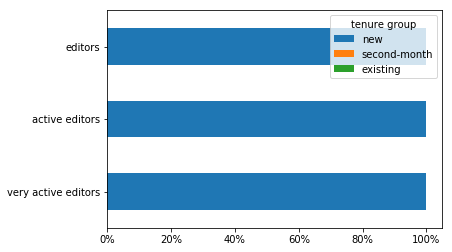

In [12]:
ax = (
    global_eds[-12:]
    .mean()
    .unstack()
    .reindex(["new", "second-month", "existing"], axis=1)
    .reindex(["very_active_eds", "active_eds", "eds"])
    .apply(lambda row: row / row.sum(), axis=1)
    .rename(index={
        "eds": "editors",
        "active_eds": "active editors",
        "very_active_eds": "very active editors"
    })
    .plot.barh(stacked=True)
)

ax.xaxis.set_major_formatter(pct_fmt)
plt.legend(title="tenure group");

# Overall trends in different activity groups

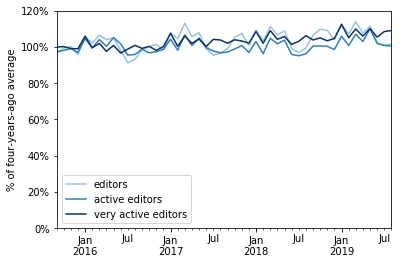

In [13]:
recent_global_eds = global_eds.sum(axis=1, level=0)[-48:]
start_index = recent_global_eds[1:13].mean()

colors = plt.get_cmap("Blues")(np.linspace(0.4, 1, 3))
ax = (
    (recent_global_eds / start_index)
    .rename(columns={
        "eds": "editors",
        "active_eds": "active editors",
        "very_active_eds": "very active editors"
    })
    .plot(ylim=(0, 1.2), color=colors)
)
plt.ylabel("% of four-years-ago average")
plt.xlabel("")
ax.yaxis.set_major_formatter(pct_fmt)

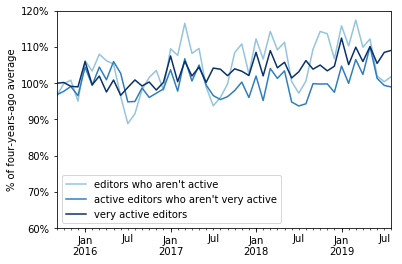

In [14]:
unnested_global_eds = (
    recent_global_eds
    .assign(
        eds=lambda df: df["eds"] - df["active_eds"] - df["very_active_eds"],
        active_eds=lambda df: df["active_eds"] - df["very_active_eds"]
    )
)

start_index = unnested_global_eds[1:13].mean()
ax = (unnested_global_eds / start_index).rename(columns={
    "eds": "editors who aren't active",
    "active_eds": "active editors who aren't very active",
    "very_active_eds": "very active editors"
}).plot(ylim=(0.6, 1.2), color=colors)
plt.ylabel("% of four-years-ago average")
plt.xlabel("")
plt.legend(loc="lower left")
ax.yaxis.set_major_formatter(pct_fmt)

# Returning active editors

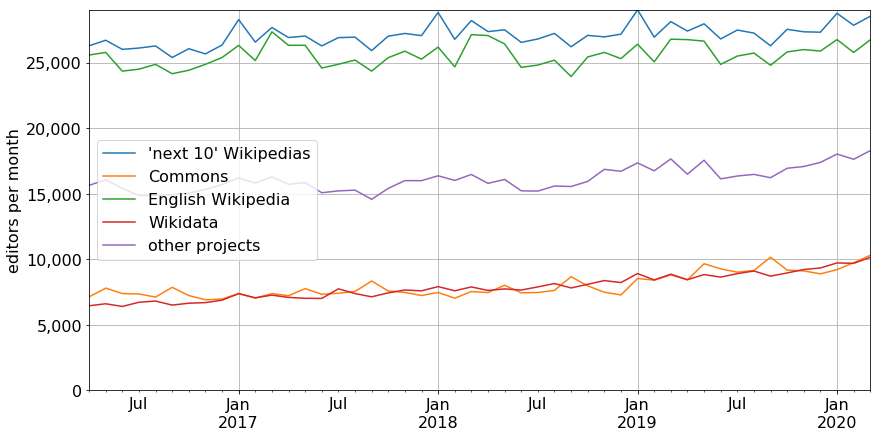

In [12]:
ax = (
    wiki_eds
    .xs(("active_eds", "returning"), axis=1, drop_level=True)
    .to_frame()
    .unstack("wiki")
    .stack([0, 1])
    .reset_index([1, 2], drop=True)
    .fillna(0)
    .groupby(wiki_segment, axis = 1).sum()
    .iloc[-48:]
    .plot(ylim=0)
)

ax.yaxis.set_major_formatter(comma_fmt)
plt.xlabel("")
plt.ylabel("editors per month");

# New active editors

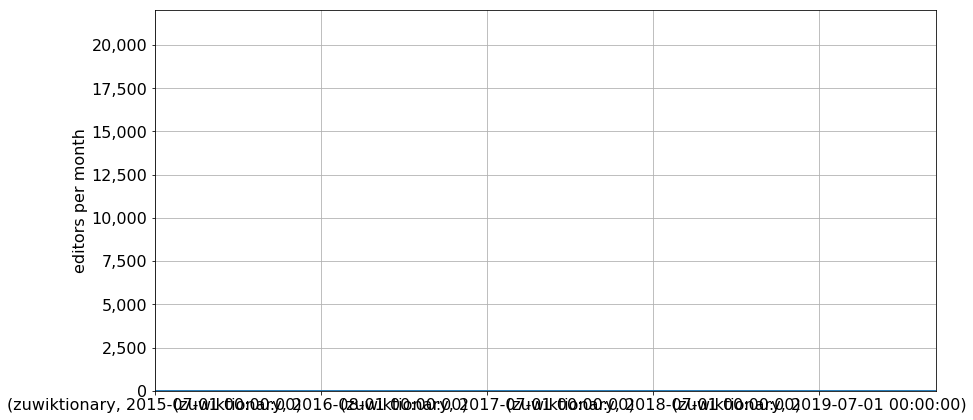

In [13]:
ax = wiki_eds[("active_eds", "new")][-48:].plot(ylim=(0, 22000))
plt.ylabel("editors per month")
plt.xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);

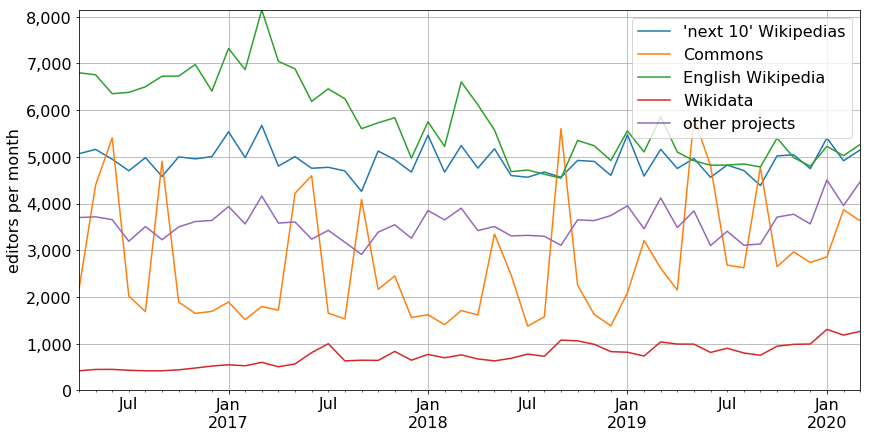

In [14]:
ax = (
    wiki_eds
    .xs(("active_eds", "new"), axis=1, drop_level=True)
    .to_frame()
    .unstack("wiki")
    .stack([0, 1])
    .reset_index([1, 2], drop=True)
    .fillna(0)
    .groupby(wiki_segment, axis = 1).sum()
    .iloc[-48:]
    .plot(ylim=0)
)

ax.yaxis.set_major_formatter(comma_fmt)
plt.xlabel("")
plt.ylabel("editors per month");

# Very active editors

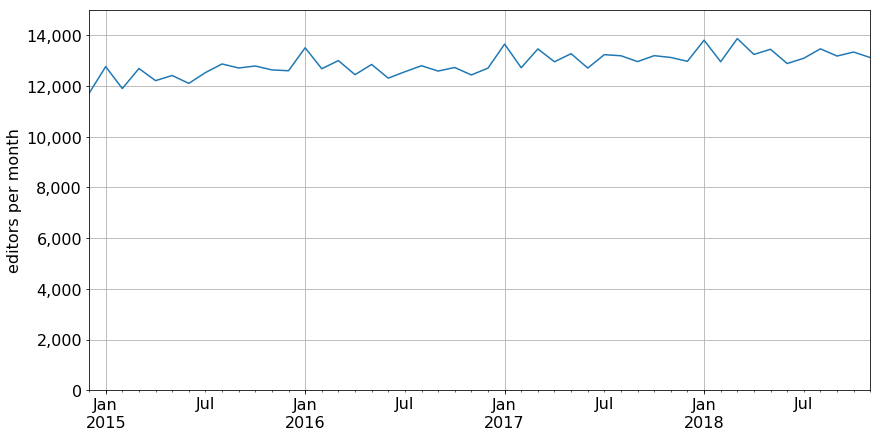

In [224]:
ax = global_eds.loc["2014-12-01":, "very_active_eds"].sum(axis=1).plot(ylim=(0, 15000))
plt.ylabel("editors per month")
plt.xlabel("")
ax.yaxis.set_major_formatter(comma_fmt);

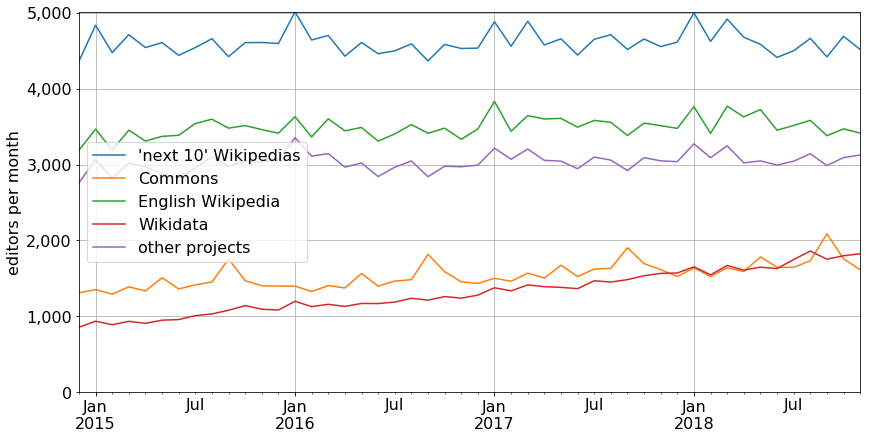

In [234]:
ax = (
    wiki_eds
    .xs(("very_active_eds"), axis=1, drop_level=True)
    .sum(axis=1)
    .unstack("wiki")
    .fillna(0)
    .groupby(wiki_segment, axis = 1).sum()
    .loc["2014-12-01":]
    .plot(ylim=0)
)

ax.yaxis.set_major_formatter(comma_fmt)
plt.xlabel("")
plt.ylabel("editors per month");